# ISLR - Python Ch8 Applied 10

- [Import Hitters Dataset](#Import-Hitters-Dataset)
- [Split the data](#Split-the-data)
- [Perform Boosting](#Perform-Boosting)
- [Compare with Linear Method](#Compare-with-Linear-Method)
- [Compare with Regularized Linear Method](#Compare-with-Regularized-Linear-Method)
- [Variable Importance](#Variable-Importance)
- [Bagging Approach](#Bagging-Approach)

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import BaggingRegressor

%matplotlib inline
plt.style.use('ggplot')

## Import Hitters Dataset

In [2]:
df = pd.read_csv('../../../data/Hitters.csv', index_col=0, )

In [3]:
# drop rows with NaNs
df = df.dropna()
# Log-transform the salaries
df.Salary = np.log(df.Salary)

In [4]:
# create dummy variables for the qualitative predictors
df = pd.get_dummies(data=df, columns=['League', 'Division', 'NewLeague'])

In [5]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,6.163315,0.0,1.0,0.0,1.0,0.0,1.0
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,6.173786,1.0,0.0,0.0,1.0,1.0,0.0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,6.214608,0.0,1.0,1.0,0.0,0.0,1.0
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,...,805,40,4,4.516339,0.0,1.0,1.0,0.0,0.0,1.0
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,6.620073,1.0,0.0,0.0,1.0,1.0,0.0


## Split the data

In [6]:
# get predictors and responses
predictors = df.columns.tolist()
predictors.remove('Salary')
X = df[predictors].values
y = df['Salary']

# split Data
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=200, random_state=0)

## Perform Boosting

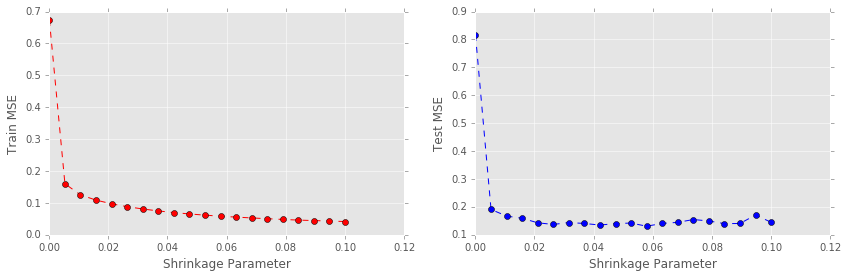

In [8]:
# Create a boosting object using 'least squares' obj func, with a variable learning rate and 1000 iterations
# each with depth of 1
train_mse = []
test_mse = []
rates = np.linspace(.0001,.1, 20)

for rate in rates:
    booster = GradientBoostingRegressor(loss='ls', learning_rate=rate, n_estimators=1000,
                                        max_depth=1, random_state=0)
    # fit the the booster to our data
    boost_est = booster.fit(X_train, y_train)
    
    # get the boost_est training error rate
    train_mse.append(np.mean((y_train-boost_est.predict(X_train))**2))
    
    # get the boost_est test error rate
    test_mse.append(np.mean((y_test-boost_est.predict(X_test))**2))
    
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
# Training MSE
ax1.plot(rates, train_mse, marker='o', color='r', linestyle='--');
ax1.set_xlabel('Shrinkage Parameter');
ax1.set_ylabel('Train MSE');
# Testing MSE
ax2.plot(rates, test_mse, marker='o', color='b', linestyle='--');
ax2.set_xlabel('Shrinkage Parameter');
ax2.set_ylabel('Test MSE');

## Compare with Linear Method

In [23]:
# Fit a linear model to predict the log(salary)
lin_est = LinearRegression(normalize=True).fit(X_train,y_train)

# get the test MSE
lin_est_mse = np.mean((lin_est.predict(X_test)-y_test)**2)

print("Linear Model has a Test MSE = ", lin_est_mse)

Linear Model has a Test MSE =  0.455494499861


## Compare with Regularized Linear Model

In [15]:
# create a grid of alphas -- the penalization in the lasso model
grid = 10**np.linspace(-4,2,100)

# compute the optimal penalization factor using cross-validation
np.random.seed(0)
lasso_cv = LassoCV(alphas=grid, normalize=True, max_iter=10000, cv=10)
lasso_cv.fit(X,y)
lasso_cv.alpha_

0.0010722672220103231

In [24]:
# Construct a Lasso Model on the training data using the optimal alpha and get the Test
# MSE
lasso = Lasso(alpha=lasso_cv.alpha_, normalize=True, max_iter=10000)
lasso.fit(X_train, y_train)
        
mse = np.mean((lasso.predict(X_test)-y_test)**2)
print("Lasso Regularized Model Test MSE = ", mse)

Lasso Regularized Model Test MSE =  0.409047112346


So the tree method outperfoms the linear and regularized linear model significantly. As stated in the chapter if the data has a linear structure then the linear methods can take advantage of the structure and outperfom the tree methods. Below is a plot of the residuals vs the fitted values. There is an asymmetry in the residual cloud indicating a nonlinearity unaccounted for in the regularized linear model. Thus we might expect the tree method to outperfom the linear methods.

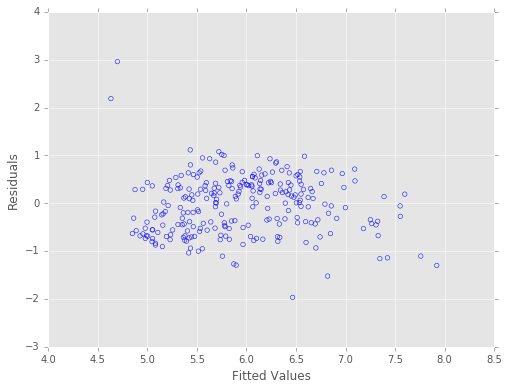

In [40]:
fig,ax = plt.subplots(1,1,figsize=(8,6));
ax.scatter(lasso.predict(X),y-lasso.predict(X), edgecolors='b', facecolors='None');
ax.set_xlabel('Fitted Values');
ax.set_ylabel('Residuals');

## Variable Importance

In [38]:
# In the boosted model we can list the importance of the features
feature_importances = boost_est.feature_importances_
pd.DataFrame(data=feature_importances, index=predictors, columns = 
             ['Importance']).sort_values(by=['Importance'], ascending=False)

,Importance
CHmRun,0.132
Years,0.130
PutOuts,0.114
Hits,0.095
CHits,0.088
CRBI,0.078
AtBat,0.062
CRuns,0.052
CAtBat,0.047
Errors,0.043


## Bagging Approach

In [42]:
# construct a bag estimator
bag_est = BaggingRegressor(random_state=0, n_estimators=500).fit(X_train,y_train)
# compute the bagging MSE
bag_mse = np.mean((bag_est.predict(X_test)-y_test)**2)
print("Bagging Test MSE = ", bag_mse)

Bagging Test MSE =  0.144182731699


so the bagging approach is comparable with the boosting approach MSE.